# Open SMAP L3 HDF5 files as `xarray.DataTree`

In [1]:
# For opening the data
from pathlib import Path
import xarray as xr

# For adding coordinates
import numpy as np
from affine import Affine
from pyproj import CRS

# For plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

DATAPATH = Path("smap_data")

In [2]:
filelist = list(DATAPATH.glob("*.h5"))

## Load a data file into an `xarray.DataTree` object

`xarray.DataTree` objects allow us to work with hierachical data structures and file formats such as HDF5, Zarr and NetCDF4 with groups.  The SMAP level 2 files are hierachical data structures.

We use `xr.open_datatree` to open a SMAP HDF5 file.  We add the `phony_dims="sort"` because data variables in the SMAP files do not have any assigned dimension scales.  `xarray` names dimensions `phony_dim0`, `phony_dim1`, etc.

In [3]:
dt = xr.open_datatree(filelist[0], phony_dims='sort')
dt

<xarray.DataTree>
Group: /
├── Group: /Metadata
│   │   Attributes:
│   │       iso_19139_dataset_xml:      <?xml version="1.0" encoding="UTF-8" standalo...
│   │       iso_19139_dataset_xml_md5:  fbe9c9d7e65ec0322f280e68b4742a86
│   │       iso_19139_series_xml:       <?xml version="1.0" encoding="UTF-8"?>\n<gmd:...
│   │       iso_19139_series_xml_md5:   3a456af04e97e0d30e03033e5e614a2f
│   ├── Group: /Metadata/AcquisitionInformation
│   │   ├── Group: /Metadata/AcquisitionInformation/platform
│   │   │       Attributes:
│   │   │           antennaRotationRate:  14.6
│   │   │           description:          The SMAP observatory houses an L-band radiometer th...
│   │   │           identifier:           SMAP
│   │   ├── Group: /Metadata/AcquisitionInformation/platformDocument
│   │   │       Attributes:
│   │   │           edition:          JPL CL#14-2285, JPL 400-1567
│   │   │           publicationDate:  2014-07-01
│   │   │           title:            SMAP Handbook
│   │   ├── Group: /Metadata/AcquisitionInformation/radar
│   │   │       Attributes:
│   │   │           description:  The SMAP 1.225 GHz L-Band Radar Instrument
│   │   │           identifier:   SMAP SAR
│   │   │           type:         L-Band Synthetic Aperture Radar
│   │   ├── Group: /Metadata/AcquisitionInformation/radarDocument
│   │   │       Attributes:
│   │   │           edition:          JPL CL#14-2285, JPL 400-1567
│   │   │           publicationDate:  2014-07-01
│   │   │           title:            SMAP Handbook
│   │   ├── Group: /Metadata/AcquisitionInformation/radiometer
│   │   │       Attributes:
│   │   │           description:  The SMAP 1.414 GHz L-Band Radiometer
│   │   │           identifier:   SMAP RAD
│   │   │           type:         L-Band Radiometer
│   │   └── Group: /Metadata/AcquisitionInformation/radiometerDocument
│   │           Attributes:
│   │               edition:          JPL CL#14-2285, JPL 400-1567
│   │               publicationDate:  2014-07-01
│   │               title:            SMAP Handbook
│   ├── Group: /Metadata/DataQuality
│   │   │   Attributes:
│   │   │       scope:    soil_moisture
│   │   ├── Group: /Metadata/DataQuality/CompletenessOmission
│   │   │       Attributes:
│   │   │           evaluationMethodType:  directInternal
│   │   │           measureDescription:    Percentage of EASE2 grid cells that lack soil mois...
│   │   │           nameOfMeasure:         Percent of Missing Data
│   │   │           unitOfMeasure:         percent
│   │   │           value:                 124.657394
│   │   └── Group: /Metadata/DataQuality/DomainConsistency
│   │           Attributes:
│   │               evaluationMethodType:  directInternal
│   │               measureDescription:    Percentage of EASE2 grid cells with soil moisture ...
│   │               nameOfMeasure:         Percentage of EASE2 grid cells with Retrieved Soil...
│   │               unitOfMeasure:         percent
│   │               value:                 100.0
│   ├── Group: /Metadata/DatasetIdentification
│   │       Attributes: (12/21)
│   │           CompositeReleaseID:             R18290
│   │           ECSVersionID:                   008
│   │           SMAPShortName:                  L3_SM_P
│   │           UUID:                           ab95f6c6-e858-4058-96ad-6493c98ade0c
│   │           abstract:                       Daily global composite of up-to 15 half-o...
│   │           characterSet:                   utf8
│   │           ...                             ...
│   │           otherCitationDetails:           The Calibration and Validation Version 2 ...
│   │           purpose:                        The SMAP L3_SM_P effort provides soil moi...
│   │           shortName:                      SPL3SMP
│   │           spatialRepresentationType:      grid
│   │           status:                         onGoing
│   │           topicCategory:                  geoscientificInformation
│   ├── Group: /Metadata/Extent
│   │       Attribu

`open_datatree` returns an `xarray.DataTree` object that we assign to `dt`.  We can see from the representation of `dt` that there are three groups in the top (called `root`) level.  Clicking on **Groups** reveals that the three groups are `Metadata`, `Soil_Moisture_Retrieval_Data_AM`, and `Soil_Moisture_Retrieval_Data_PM`.  We can also see that there are no dimensions, coordinates, data variables or attributes in the `root` group. 

The `Metadata` group has 11 sub-groups that contain information about data quality and the SMAP instrument.  `Soil_Moisture_Retrieval_Data_AM` and `Soil_Moisture_Retrieval_Data_PM` don't have any subgroups but they each contain 53 variables.  We can also see the names and sizes of the Phony Dimensions.  We can also see that the phony dimensions for each group have the same sizes; `phony_dim0` is the same size as `phony_dim3`, `phony_dim1` is the same size as `phony_dim4` and `phony_dim2` is the same size as `phony_dim3`.  In fact, `phony_dim0` and `phony_dim3` are the `y` dimension of the data grids; `phony_dim1` and `phony_dim4` are the `x` dimension; and `phony_dim2` and `phony_dim5` are the number of IGBP land cover classes.

### Add coordinates to the data

Adding coordinates to the data variables allows us to work with the data as a geospatial dataset: performing geospatial analyses, reprojecting the data and making maps.

First, we will change the names of the _phony dims_ to be more meaningful: `x`, `y` and `igbp_class`.  We do this by using `rename` to rename the dimensions.  To use `rename` we also have to use the dataset accessor `ds` and overwrite the othe soil moisture variables.  After each renaming, we update the soil moisture variable in the datatree to align the common dimensions. 

In [4]:
dt["Soil_Moisture_Retrieval_Data_AM"] = \
  dt["Soil_Moisture_Retrieval_Data_AM"].ds.rename(
      {
          'phony_dim_0': 'y', 
          'phony_dim_1': 'x', 
          'phony_dim_2': 'igbp_class'
      }
  )
dt.update(other=dt["Soil_Moisture_Retrieval_Data_AM"])

dt["Soil_Moisture_Retrieval_Data_PM"] = \
  dt["Soil_Moisture_Retrieval_Data_PM"].ds.rename(
      {
          'phony_dim_3': 'y', 
          'phony_dim_4': 'x', 
          'phony_dim_5': 'igbp_class'
      }
  )
dt.update(other=dt["Soil_Moisture_Retrieval_Data_PM"])

In [5]:
dt

<xarray.DataTree>
Group: /
│   Dimensions:                         (y: 406, x: 964, igbp_class: 3)
│   Dimensions without coordinates: y, x, igbp_class
│   Data variables: (12/106)
│       EASE_column_index               (y, x) float32 2MB ...
│       EASE_row_index                  (y, x) float32 2MB ...
│       albedo                          (y, x) float32 2MB ...
│       albedo_dca                      (y, x) float32 2MB ...
│       albedo_scah                     (y, x) float32 2MB ...
│       albedo_scav                     (y, x) float32 2MB ...
│       ...                              ...
│       tb_v_uncorrected_pm             (y, x) float32 2MB ...
│       vegetation_opacity_dca_pm       (y, x) float32 2MB ...
│       vegetation_opacity_pm           (y, x) float32 2MB ...
│       vegetation_opacity_scah_pm      (y, x) float32 2MB ...
│       vegetation_opacity_scav_pm      (y, x) float32 2MB ...
│       vegetation_water_content_pm     (y, x) float32 2MB ...
├── Group: /Metadata
│   │   Attributes:
│   │       iso_19139_dataset_xml:      <?xml version="1.0" encoding="UTF-8" standalo...
│   │       iso_19139_dataset_xml_md5:  fbe9c9d7e65ec0322f280e68b4742a86
│   │       iso_19139_series_xml:       <?xml version="1.0" encoding="UTF-8"?>\n<gmd:...
│   │       iso_19139_series_xml_md5:   3a456af04e97e0d30e03033e5e614a2f
│   ├── Group: /Metadata/AcquisitionInformation
│   │   ├── Group: /Metadata/AcquisitionInformation/platform
│   │   │       Attributes:
│   │   │           antennaRotationRate:  14.6
│   │   │           description:          The SMAP observatory houses an L-band radiometer th...
│   │   │           identifier:           SMAP
│   │   ├── Group: /Metadata/AcquisitionInformation/platformDocument
│   │   │       Attributes:
│   │   │           edition:          JPL CL#14-2285, JPL 400-1567
│   │   │           publicationDate:  2014-07-01
│   │   │           title:            SMAP Handbook
│   │   ├── Group: /Metadata/AcquisitionInformation/radar
│   │   │       Attributes:
│   │   │           description:  The SMAP 1.225 GHz L-Band Radar Instrument
│   │   │           identifier:   SMAP SAR
│   │   │           type:         L-Band Synthetic Aperture Radar
│   │   ├── Group: /Metadata/AcquisitionInformation/radarDocument
│   │   │       Attributes:
│   │   │           edition:          JPL CL#14-2285, JPL 400-1567
│   │   │           publicationDate:  2014-07-01
│   │   │           title:            SMAP Handbook
│   │   ├── Group: /Metadata/AcquisitionInformation/radiometer
│   │   │       Attributes:
│   │   │           description:  The SMAP 1.414 GHz L-Band Radiometer
│   │   │           identifier:   SMAP RAD
│   │   │           type:         L-Band Radiometer
│   │   └── Group: /Metadata/AcquisitionInformation/radiometerDocument
│   │           Attributes:
│   │               edition:          JPL CL#14-2285, JPL 400-1567
│   │               publicationDate:  2014-07-01
│   │               title:            SMAP Handbook
│   ├── Group: /Metadata/DataQuality
│   │   │   Attributes:
│   │   │       scope:    soil_moisture
│   │   ├── Group: /Metadata/DataQuality/CompletenessOmission
│   │   │       Attributes:
│   │   │           evaluationMethodType:  directInternal
│   │   │           measureDescription:    Percentage of EASE2 grid cells that lack soil mois...
│   │   │           nameOfMeasure:         Percent of Missing Data
│   │   │           unitOfMeasure:         percent
│   │   │           value:                 124.657394
│   │   └── Group: /Metadata/DataQuality/DomainConsistency
│   │           Attributes:
│   │               evaluationMethodType:  directInternal
│   │               measureDescription:    Percentage of EASE2 grid cells with soil moisture ...
│   │               nameOfMeasure:         Percentage of EASE2 grid cells with Retrieved Soil...
│   │               unitOfMeasure:         percent
│   │               value:                 100.0
│   ├── Group: /Metadata/DatasetIdentificatio

We can now see that `x`, `y` and `igbp_class` dimensions are in the root group.

Now we can add coordinates values.  We will generate coordinates using an Affine matrix. See [working_with_smap_in_xarray.ipynb](./working_with_smap_in_xarray.ipynb) for an explanation of this step.

In [6]:
grid_cell_width = 36032.220840584
grid_cell_height = -36032.220840584
x_upper_left_corner = -17367530.4451615
y_upper_left_corner = 7314540.8306386

transform = Affine(grid_cell_width, 0.0, x_upper_left_corner, 
                   0.0, grid_cell_height, y_upper_left_corner)

nrows, ncolumns, nclass = dt.dims['y'], dt.dims['x'], dt.dims['igbp_class']  #data_vars['soil_moisture'][1].shape
row = np.arange(0.5, nrows)
column = np.arange(0.5, ncolumns)

x, _ = transform * (column, 0.5)
_, y = transform * (0.5, row)
igbp_class = np.arange(nclass)  # Add attributes

We then assign coordinate variables to the DataTree as `xarray.DataArrays`.

In [7]:
dt = dt.assign(
    {
        'x': xr.DataArray(x, dims='x'),
        'y': xr.DataArray(y, dims='y'),
        'igbp_class': xr.DataArray(igbp_class, dims='igbp_class')
    }
)
dt

<xarray.DataTree>
Group: /
│   Dimensions:                         (y: 406, x: 964, igbp_class: 3)
│   Coordinates:
│     * x                               (x) float64 8kB -1.735e+07 ... 1.735e+07
│     * y                               (y) float64 3kB 7.297e+06 ... -7.297e+06
│     * igbp_class                      (igbp_class) int64 24B 0 1 2
│   Data variables: (12/106)
│       EASE_column_index               (y, x) float32 2MB ...
│       EASE_row_index                  (y, x) float32 2MB ...
│       albedo                          (y, x) float32 2MB ...
│       albedo_dca                      (y, x) float32 2MB ...
│       albedo_scah                     (y, x) float32 2MB ...
│       albedo_scav                     (y, x) float32 2MB ...
│       ...                              ...
│       tb_v_uncorrected_pm             (y, x) float32 2MB ...
│       vegetation_opacity_dca_pm       (y, x) float32 2MB ...
│       vegetation_opacity_pm           (y, x) float32 2MB ...
│       vegetation_opacity_scah_pm      (y, x) float32 2MB ...
│       vegetation_opacity_scav_pm      (y, x) float32 2MB ...
│       vegetation_water_content_pm     (y, x) float32 2MB ...
├── Group: /Metadata
│   │   Attributes:
│   │       iso_19139_dataset_xml:      <?xml version="1.0" encoding="UTF-8" standalo...
│   │       iso_19139_dataset_xml_md5:  fbe9c9d7e65ec0322f280e68b4742a86
│   │       iso_19139_series_xml:       <?xml version="1.0" encoding="UTF-8"?>\n<gmd:...
│   │       iso_19139_series_xml_md5:   3a456af04e97e0d30e03033e5e614a2f
│   ├── Group: /Metadata/AcquisitionInformation
│   │   ├── Group: /Metadata/AcquisitionInformation/platform
│   │   │       Attributes:
│   │   │           antennaRotationRate:  14.6
│   │   │           description:          The SMAP observatory houses an L-band radiometer th...
│   │   │           identifier:           SMAP
│   │   ├── Group: /Metadata/AcquisitionInformation/platformDocument
│   │   │       Attributes:
│   │   │           edition:          JPL CL#14-2285, JPL 400-1567
│   │   │           publicationDate:  2014-07-01
│   │   │           title:            SMAP Handbook
│   │   ├── Group: /Metadata/AcquisitionInformation/radar
│   │   │       Attributes:
│   │   │           description:  The SMAP 1.225 GHz L-Band Radar Instrument
│   │   │           identifier:   SMAP SAR
│   │   │           type:         L-Band Synthetic Aperture Radar
│   │   ├── Group: /Metadata/AcquisitionInformation/radarDocument
│   │   │       Attributes:
│   │   │           edition:          JPL CL#14-2285, JPL 400-1567
│   │   │           publicationDate:  2014-07-01
│   │   │           title:            SMAP Handbook
│   │   ├── Group: /Metadata/AcquisitionInformation/radiometer
│   │   │       Attributes:
│   │   │           description:  The SMAP 1.414 GHz L-Band Radiometer
│   │   │           identifier:   SMAP RAD
│   │   │           type:         L-Band Radiometer
│   │   └── Group: /Metadata/AcquisitionInformation/radiometerDocument
│   │           Attributes:
│   │               edition:          JPL CL#14-2285, JPL 400-1567
│   │               publicationDate:  2014-07-01
│   │               title:            SMAP Handbook
│   ├── Group: /Metadata/DataQuality
│   │   │   Attributes:
│   │   │       scope:    soil_moisture
│   │   ├── Group: /Metadata/DataQuality/CompletenessOmission
│   │   │       Attributes:
│   │   │           evaluationMethodType:  directInternal
│   │   │           measureDescription:    Percentage of EASE2 grid cells that lack soil mois...
│   │   │           nameOfMeasure:         Percent of Missing Data
│   │   │           unitOfMeasure:         percent
│   │   │           value:                 124.657394
│   │   └── Group: /Metadata/DataQuality/DomainConsistency
│   │           Attributes:
│   │               evaluationMethodType:  directInternal
│   │               measureDescription:    Percentage of EASE2 grid cells with soil moisture ...
│   │               nameOfMeasure:         Perc

Now that we have the coordinates added to the DataTree we can plot data on a map with coastlines or other features we want to add.

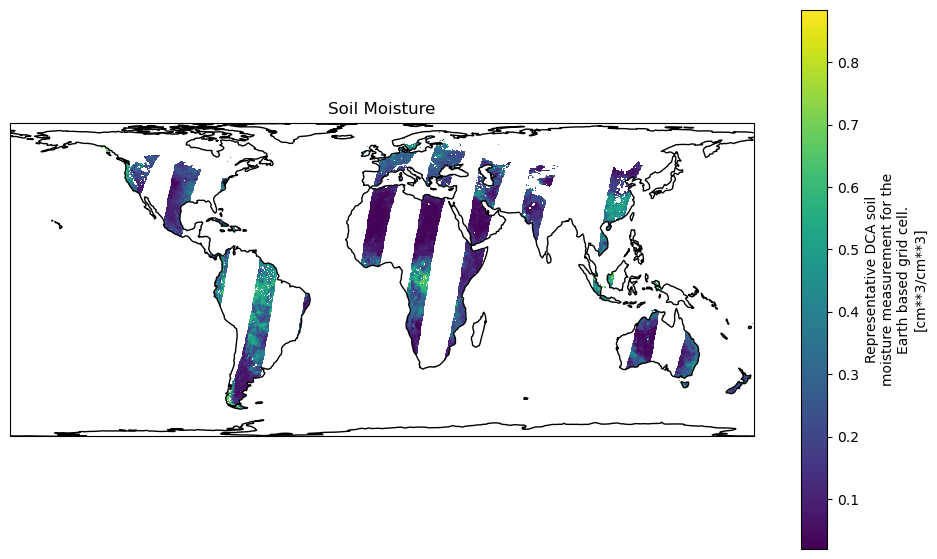

In [8]:
EASEGrid2 = ccrs.epsg(CRS.from_epsg(6933).to_epsg())

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection=EASEGrid2)

dt["Soil_Moisture_Retrieval_Data_AM"].soil_moisture.plot(ax=ax)
ax.coastlines()
ax.set_title('Soil Moisture');